In [1]:
from numpy import array, zeros, ones, sin, cos, pi, sqrt, sign, abs, exp, sum, min, copy, logical_and, hstack, vstack, argmin, all, any
from scipy.spatial.distance import cdist
from numpy.random import rand, randn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

In [2]:
# Define network class.
class network(object):
    def __init__(self):
        # Set reagent concentrations.
        actin_conc = 5.0
        arp23_conc = 50.0 * 10**-3
        cp_conc = 200.0 * 10**-3
        
        # Estimate association rates.
        self.elongate_rate = 11 * actin_conc
        self.cap_rate = cp_conc * 11 * (42.0 / 63.0)**(1/3)
        self.actin_load_rate = 11 * actin_conc
        self.actin_transfer_rate = 1.0 # PPR to WH2. Have no idea how fast this should be.
        self.arp23_load_rate = 11 * arp23_conc * (42.0 / 220.0)**(1/3)
        self.untether_rate = 1.0
        self.no_ends = 200
        
        # Declare constants.
        self.square_length = 1.0 # in microns
        self.monomer_length = 2.7 * 10**-3 # in microns.
        self.payload_distance = 20 * 10**-3 # in microns.
        self.mu_theta = 70 / 180 * pi # mean angle at branches, in radians
        self.mu_sigma = 5 / 180 * pi # variance of angle at branches, in radians
        self.bond_stiffness = 1.0 * 10**3
        self.tether_force_scale = 10.0
        self.total_simulation_time = 1.0 # in seconds
        self.time_interval = 1e-3 # in seconds
        self.current_time = 0.0 # in seconds

        # Initialize ends.
        x_end_col = self.square_length * (rand(self.no_ends, 1) - 0.5)
        y_end_col = self.square_length * (rand(self.no_ends, 1) - 0.5)
        z_end_col = self.monomer_length * rand(self.no_ends, 1) + self.monomer_length
        self.xyz_end_mat = hstack((x_end_col, y_end_col, z_end_col))
        
        azi_angle_col = 2 * pi * rand(self.no_ends, 1)
        polar_angle_col = 0.5 * pi * (1 + rand(self.no_ends, 1))
        ux_end_col = sin(polar_angle_col) * cos(azi_angle_col)
        uy_end_col = sin(polar_angle_col) * sin(azi_angle_col)
        uz_end_col = cos(polar_angle_col)
        self.u_end_mat = hstack((ux_end_col, uy_end_col, uz_end_col))
        
        self.is_capped_col = zeros((self.no_ends, 1), dtype = bool)
        self.is_tethered_col = zeros((self.no_ends, 1), dtype = bool)
        self.tether_force_col = zeros((self.no_ends, 1))
        self.compression_factor = 1.0
        self.untether_rate_col = zeros((self.no_ends, 1))
        
        self.no_from_sol = 0
        self.no_from_npf = 0
        
        # Initialize npfs.
        self.npf_density = 1000
        self.no_npfs = int(self.npf_density / self.square_length**2)
        x_npf_col = self.square_length * (rand(self.no_npfs, 1) - 0.5)
        y_npf_col = self.square_length * (rand(self.no_npfs, 1) - 0.5)
        z_npf_col = self.square_length * zeros((self.no_npfs, 1))
        self.xyz_npf_mat = hstack((x_npf_col, y_npf_col, z_npf_col))
        self.npf_state_mat = zeros((self.no_npfs, 3)) # PPR, WH2, and CA bound states.
            
    def find_end(self, index):
        distance_end_col = cdist(self.xyz_end_mat, array([self.xyz_npf_mat[index, :]]))
        npf2end_distance = min(distance_end_col)
        index_end = argmin(distance_end_col)
        return index_end, npf2end_distance
        
    def elongate(self, index):
        self.xyz_end_mat[index] = self.xyz_end_mat[index] + self.monomer_length * self.u_end_mat[index]
        # Enforce periodic boundary conditions.
        if abs(self.xyz_end_mat[index, 0]) > 0.5 * self.square_length:
            self.xyz_end_mat[index, 0] -= sign(self.xyz_end_mat[index, 0]) * self.square_length
        if abs(self.xyz_end_mat[index, 1]) > 0.5 * self.square_length:
            self.xyz_end_mat[index, 1] -= sign(self.xyz_end_mat[index, 1]) * self.square_length
                 
    def branch(self, index):
        def rotation_angle_axis(ux_axis, uy_axis, uz_axis, theta_axis):
            R_11 = cos(theta_axis) + ux_axis**2 * (1 - cos(theta_axis))
            R_12 = ux_axis * uy_axis * (1 - cos(theta_axis)) - uz_axis * sin(theta_axis)
            R_13 = ux_axis * uz_axis * (1 - cos(theta_axis)) + uy_axis * sin(theta_axis)
            R_21 = uy_axis * ux_axis * (1 - cos(theta_axis)) + uz_axis * sin(theta_axis)
            R_22 = cos(theta_axis) + uy_axis**2 * (1 - cos(theta_axis))
            R_23 = uy_axis * uz_axis * (1 - cos(theta_axis)) - ux_axis * sin(theta_axis)
            R_31 = uz_axis * ux_axis * (1 - cos(theta_axis)) - uy_axis * sin(theta_axis)
            R_32 = uz_axis * uy_axis * (1 - cos(theta_axis)) + ux_axis * sin(theta_axis)
            R_33 = cos(theta_axis) + uz_axis**2 * (1 - cos(theta_axis))
            rotation_mat = array([[R_11, R_12, R_13], [R_21, R_22, R_23], [R_31, R_32, R_33]])
            return rotation_mat
        
        ux_old, uy_old, uz_old = self.u_end_mat[index]
        
        # Find an axis perpendicular to orientation of ended end.
        u_perp_mag = sqrt(2 + (ux_old + uy_old)**2)
        ux_perp_old = 1.0 / u_perp_mag
        uy_perp_old = 1.0 / u_perp_mag
        uz_perp_old = -(ux_old + uy_old) / u_perp_mag
        
        # Perform rotation to find new orientation.
        theta_polar = self.mu_theta + self.mu_sigma * randn()
        theta_azi = 2 * pi * rand()
        polar_rotation_mat = rotation_angle_axis(ux_perp_old, uy_perp_old, uz_perp_old, theta_polar)
        u_new_polar_row = polar_rotation_mat @ array([ux_old, uy_old, uz_old])
        azi_rotation_mat = rotation_angle_axis(ux_old, uy_old, uz_old, theta_azi)
        u_new_row = azi_rotation_mat @ u_new_polar_row
        
        # Do it until it's facing the right way (-z).
        while u_new_row[2] >= 0.0:
            theta_polar = self.mu_theta + self.mu_sigma * randn()
            theta_azi = 2 * pi * rand()
            polar_rotation_mat = rotation_angle_axis(ux_perp_old, uy_perp_old, uz_perp_old, theta_polar)
            u_new_polar_row = polar_rotation_mat @ array([ux_old, uy_old, uz_old])
            azi_rotation_mat = rotation_angle_axis(ux_old, uy_old, uz_old, theta_azi)
            u_new_row = azi_rotation_mat @ u_new_polar_row
                        
        # Add new ended end to relevant arrays.
        self.xyz_end_mat = vstack((self.xyz_end_mat, self.xyz_end_mat[index]))
        self.u_end_mat = vstack((self.u_end_mat, u_new_row))
        self.is_capped_col = vstack((self.is_capped_col, array([False])))
        self.is_tethered_col = vstack((self.is_tethered_col, array([False])))
        self.no_ends += 1
            
    def cap(self, index):
        self.is_capped_col[index] = True
    
    def tether(self, index):
        self.is_tethered_col[index, 0] = True
        self.tether_force_col[index, 0] = self.bond_stiffness * self.xyz_end_mat[index, 2]
        self.untether_rate_col[index, 0] = self.untether_rate * exp(self.tether_force_col[index] / self.tether_force_scale)
    
    def untether(self, index):
        self.is_tethered_col[index, 0] = False
        self.tether_force_col[index, 0] = 0.0
        self.untether_rate_col[index, 0] = 0.0
        
    def tether_mechanics(self):
        total_tether_force = sum(self.tether_force_col)
        no_proximal_ends = sum(logical_and(self.xyz_end_mat[:, 2] <= self.monomer_length, ~self.is_capped_col[:, 0]))
        if no_proximal_ends > 1:
            mean_compressive_force = total_tether_force / no_proximal_ends
        else:
            mean_compressive_force = 0
        self.compression_factor = exp(-mean_compressive_force * self.monomer_length / 4.114)
    
    def update_step(self):
        # Deal with ends in solution.
        for i_end in range(self.no_ends):
            if self.xyz_end_mat[i_end, 2] > self.monomer_length:
                if self.is_capped_col[i_end, 0] == False:
                    if exp(-self.elongate_rate * self.time_interval) < rand():
                        self.elongate(i_end)
                    elif exp(-self.cap_rate * self.time_interval) < rand():
                        self.cap(i_end)
                        
        # Deal with npfs and proximal ends.
        for i_npf in range(self.no_npfs):
            # Find nearest end.
            i_index_end, i_distance2end = self.find_end(i_npf)
            if i_distance2end <= self.payload_distance:
                if all(self.npf_state_mat[i_npf] == [0, 0, 0]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    self.tether(i_index_end)
                    self.npf_state_mat[i_npf, 1] = -1
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 2] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [1, 0, 0]):
                    self.elongate(i_index_end)
                    self.npf_state_mat[i_npf, 0] = 0
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 2] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [0, -1, 0]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    if exp(-self.untether_rate_col[i_index_end, 0] * self.time_interval) < rand():
                        self.untether(i_index_end)
                        self.npf_state_mat[i_npf, 1] = 0
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 2] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [1, -1, 0]):
                    if exp(-self.untether_rate_col[i_index_end, 0]) * self.time_interval < rand():
                        self.untether(i_index_end)
                        self.npf_state_mat[i_npf, 1] = 0
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 2] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [0, 1, 0]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    self.elongate(i_index_end)
                    self.npf_state_mat[i_npf, 1] = 0
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [1, 1, 0]):
                    self.elongate(i_index_end)
                    if rand() < 0.5:
                        self.npf_state_mat[i_npf, 0] = 0
                    else:
                        self.npf_state_mat[i_npf, 1] = 0
                    if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 2] = 1
                    continue
                elif all(self.npf_state_mat[i_npf] == [0, 0, 1]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    self.tether(i_index_end)
                    self.npf_state_mat[i_npf, 1] = -1
                    continue
                elif all(self.npf_state_mat[i_npf] == [1, 0, 1]):
                    self.elongate(i_index_end)
                    self.npf_state_mat[i_npf, 0] = 0
                    continue
                elif all(self.npf_state_mat[i_npf] == [0, -1, 1]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    if exp(-self.untether_rate_col[i_index_end, 0] * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 1] = 0
                    continue
                elif all(self.npf_state_mat[i_npf] == [1, -1, 1]):
                    if exp(-self.untether_rate_col[i_index_end, 0] * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 1] = 0
                    continue
                elif all(self.npf_state_mat[i_npf] == [0, 1, 1]):
                    if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                        self.npf_state_mat[i_npf, 0] = 1
                    self.branch(i_index_end)
                    self.npf_state_mat[i_npf, 1] = 0
                    self.npf_state_mat[i_npf, 2] = 0
                elif all(self.npf_state_mat[i_npf] == [1, 1, 1]):
                    if rand() < 0.5:
                        self.elongate(i_index_end)
                        self.npf_state_mat[i_npf, 0] = 0
                    else:
                        self.branch(i_index_end)
                        self.npf_state_mat[i_npf, 1] = 0
                        self.npf_state_mat[i_npf, 2] = 0
            elif all(self.npf_state_mat[i_npf] == [0, 0, 0]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, 0, 0]):
                if exp(-self.actin_transfer_rate * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 0
                    self.npf_state_mat[i_npf, 1] = 1
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [0, -1, 0]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, -1, 0]):
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [0, 1, 0]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, 1, 0]):
                if exp(-self.arp23_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 2] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [0, 0, 1]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, 0, 1]):
                if exp(-self.actin_transfer_rate * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 0
                    self.npf_state_mat[i_npf, 1] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [0, -1, 1]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, -1, 1]):
                continue
            elif all(self.npf_state_mat[i_npf] == [0, 1, 1]):
                if exp(-self.actin_load_rate * self.compression_factor * self.time_interval) < rand():
                    self.npf_state_mat[i_npf, 0] = 1
                continue
            elif all(self.npf_state_mat[i_npf] == [1, 1, 1]):
                continue
        
        # Update space, time, and mechanics.
        self.current_time += self.time_interval
        self.tether_mechanics()
        if any(self.xyz_end_mat[:, 2] < 0):
            self.xyz_end_mat[:, 2] -= min(self.xyz_end_mat[:, 2])
    
    def simulate(self):
        while (self.current_time <= self.total_simulation_time) and (sum(~self.is_capped_col) >= 1):
            self.update_step()
    
    def display_network(self):
        fig1_hand = figure()
        axes1_hand = fig1_hand.add_subplot(111, projection = '3d')
        axes1_hand.quiver(self.xyz_end_mat[:, 0], self.xyz_end_mat[:, 1], self.xyz_end_mat[:, 2], 
                          self.u_end_mat[:, 0], self.u_end_mat[:, 1], self.u_end_mat[:, 2], length = self.monomer_length)
        axes1_hand.scatter(self.xyz_npf_mat[:, 0], self.xyz_npf_mat[:, 1], self.xyz_npf_mat[:, 2], '.', color = 'red')

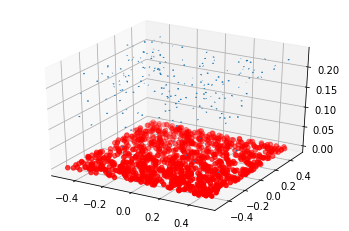

In [3]:
test_network = network()
test_network.simulate()
test_network.display_network()

In [10]:
test_network.npf_state_mat

array([[ 1.,  0.,  0.],
       [ 1., -1.,  1.],
       [ 1., -1.,  0.],
       ...,
       [ 1.,  1.,  1.],
       [ 1.,  1.,  0.],
       [ 1., -1.,  0.]])

In [13]:
max(test_network.xyz_end_mat[:, 2]) / test_network.current_time * 60

13.831305527334397